## 4-1

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision.models import resnet18
import pandas as pd
import os
from PIL import Image
import cv2
import numpy as np


c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Custom dataset class
class MNISTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = [f for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.samples[idx])
        img = cv2.imread(img_name)
        
        if self.transform:
                img = self.transform(img)
        
        if self.root_dir.split('_')[2]=='train':
            
            label_file = img_name.replace('.png', '.txt')
            with open(label_file, 'r') as f:
                label = int(f.readline()[0])

            return img, label
        else:
            return img, self.samples[idx]

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])


In [3]:
from sklearn.model_selection import StratifiedShuffleSplit


def create_stratified_split(dataset, test_size=0.2):
    labels = []
    for _, label_path in enumerate(dataset.samples):
        label_file = os.path.join(dataset.root_dir, label_path).replace('.png', '.txt')
        with open(label_file, 'r') as f:
            label = int(f.readline().strip()[0])
        labels.append(label)

    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=0)
    train_idx, valid_idx = next(sss.split(np.zeros(len(labels)), labels))
    return train_idx, valid_idx

# Create dataset
train_dataset = MNISTDataset('../HW2/HW2_MNIST_train', transform=transform)

# If val_flag is true, create stratified split
val_flag = True
if val_flag:
    train_idx, valid_idx = create_stratified_split(train_dataset)

    # Create samplers
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # Create loaders
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)
else:
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [4]:
def count_classes(dataset, indices):
    class_counts = {}
    for idx in indices:
        img_name = os.path.join(dataset.root_dir, dataset.samples[idx])
        label_file = img_name.replace('.png', '.txt')
        with open(label_file, 'r') as f:
            label = int(f.readline().strip()[0])
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    return class_counts

# Count classes in the training set
train_class_counts = count_classes(train_dataset, train_idx)
print("Training set class counts:", train_class_counts)

# Count classes in the validation set
valid_class_counts = count_classes(train_dataset, valid_idx)
print("Validation set class counts:", valid_class_counts)


Training set class counts: {6: 7579, 7: 8005, 5: 6950, 1: 8668, 2: 7625, 8: 7542, 9: 7619, 4: 7451, 0: 8628, 3: 7849}
Validation set class counts: {4: 1863, 2: 1906, 3: 1963, 5: 1737, 6: 1895, 9: 1905, 8: 1885, 0: 2157, 1: 2167, 7: 2002}


In [5]:
import torch.nn as nn
import torch.optim as optim
from datetime import datetime

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# RNN models
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, rnn_type):
        super(RNNClassifier, self).__init__()
        if rnn_type == 'SimpleRNN':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        out, _ = self.rnn(x)
        # take the last sequence to output
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# hyperparameters
input_size = 256  # patch size (16x16)
hidden_size = [64,64,256]  # RNN hidden layer
num_layers = [1,2,4]  # RNN layers
num_classes = 10  
seq_length = 64  # 圖像轉換成序列的長度 (128x128 圖像分割成8x8塊，每塊16x16)

# define model
models = {
    'SimpleRNN': RNNClassifier(input_size, hidden_size[0], num_layers[0], num_classes, 'SimpleRNN'),
    'LSTM': RNNClassifier(input_size, hidden_size[1], num_layers[1], num_classes, 'LSTM'),
    'GRU': RNNClassifier(input_size, hidden_size[2], num_layers[2], num_classes, 'GRU'),
}

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizers = {m: optim.Adam(model.parameters(), lr=0.001) for m, model in models.items()}

# function: image to sequence
def image_to_seq(image, block_size=16):
    # segment image into patches 
    patches = image.unfold(2, block_size, block_size).unfold(3, block_size, block_size)
    patches = patches.contiguous().view(image.size(0), -1, block_size*block_size)
    return patches

# training epoch
num_epochs = 15
for model_name, model in models.items():
    print(f'Start training {model_name}:')
    model = model.to(device)
    optimizer = optimizers[model_name]
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        val_loss, val_correct, val_total = 0.0, 0, 0

        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            images_seq = image_to_seq(images)
            
            outputs = model(images_seq)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        
        train_acc = train_correct / train_total
        
        if val_flag:
            model.eval()
            with torch.no_grad():
                for images, labels in valid_loader:
                    images, labels = images.to(device), labels.to(device)
                    images_seq = image_to_seq(images)
                    outputs = model(images_seq)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            val_acc = val_correct / val_total
            print(f'Epoch [{epoch+1}/{num_epochs}], {model_name} Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss / len(valid_loader):.4f}, Val Accuracy: {val_acc:.4f}')
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), f'best_{model_name}.pth')
        else:
            print(f'Epoch [{epoch+1}/{num_epochs}], {model_name} Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_acc:.4f}')
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    torch.save(model.state_dict(), f'{model_name}_{timestamp}.pth')


Using device: cuda:0
Start training SimpleRNN:
Epoch [1/15], SimpleRNN Train Loss: 2.2995, Train Accuracy: 0.1152, Val Loss: 2.2967, Val Accuracy: 0.1137
Epoch [2/15], SimpleRNN Train Loss: 2.2971, Train Accuracy: 0.1184, Val Loss: 2.2855, Val Accuracy: 0.1368
Epoch [3/15], SimpleRNN Train Loss: 2.2904, Train Accuracy: 0.1284, Val Loss: 2.2168, Val Accuracy: 0.1689
Epoch [4/15], SimpleRNN Train Loss: 2.2918, Train Accuracy: 0.1168, Val Loss: 2.2993, Val Accuracy: 0.1163
Epoch [5/15], SimpleRNN Train Loss: 2.2501, Train Accuracy: 0.1371, Val Loss: 2.2073, Val Accuracy: 0.1622
Epoch [6/15], SimpleRNN Train Loss: 2.2497, Train Accuracy: 0.1384, Val Loss: 2.2717, Val Accuracy: 0.1136
Epoch [7/15], SimpleRNN Train Loss: 2.3037, Train Accuracy: 0.1062, Val Loss: 2.3026, Val Accuracy: 0.1130
Epoch [8/15], SimpleRNN Train Loss: 2.3044, Train Accuracy: 0.1085, Val Loss: 2.3055, Val Accuracy: 0.1113
Epoch [9/15], SimpleRNN Train Loss: 2.3043, Train Accuracy: 0.1083, Val Loss: 2.3060, Val Accurac

In [8]:
# Number of layers and parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_parameters = count_parameters(models['SimpleRNN'])
print("Number of trainable parameters(SimpleRNN): ", num_parameters)

num_parameters = count_parameters(models['LSTM'])
print("Number of trainable parameters(LSTM): ", num_parameters)

num_parameters = count_parameters(models['GRU'])
print("Number of trainable parameters(GRU): ", num_parameters)


Number of trainable parameters(SimpleRNN):  21258
Number of trainable parameters(LSTM):  116362
Number of trainable parameters(GRU):  1581578


In [7]:
test_dataset = MNISTDataset('../HW2/HW2_MNIST_test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = RNNClassifier(input_size, hidden_size[2], num_layers[2], num_classes, 'GRU')

# load model
model_path = 'best_GRU.pth'  
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)


# Perform predictions on the test set
model.eval()  
predictions = []
image_files = []

with torch.no_grad():
    for data in test_loader:
        images, file_names = data
        images = images.to(device)
        images_seq = image_to_seq(images)
        outputs = model(images_seq)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        image_files.extend(file_names)

# Save to CSV
predictions_df = pd.DataFrame({
    'image': image_files,
    'class': predictions
})
predictions_df.to_csv('HW4_prob1.csv', index=False)

## 4.2

Epoch [100/1000], Loss: 0.0000
Epoch [200/1000], Loss: 0.0000
Epoch [300/1000], Loss: 0.0000
Epoch [400/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000


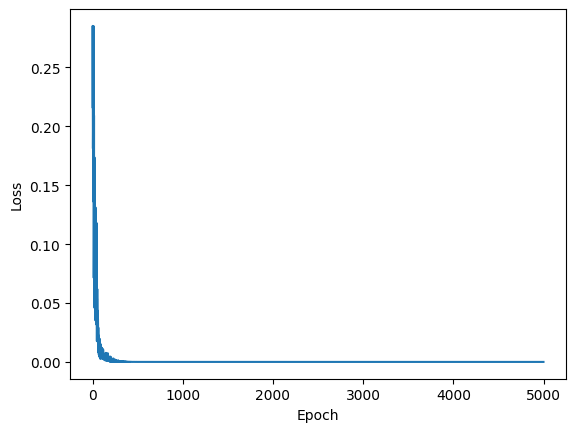

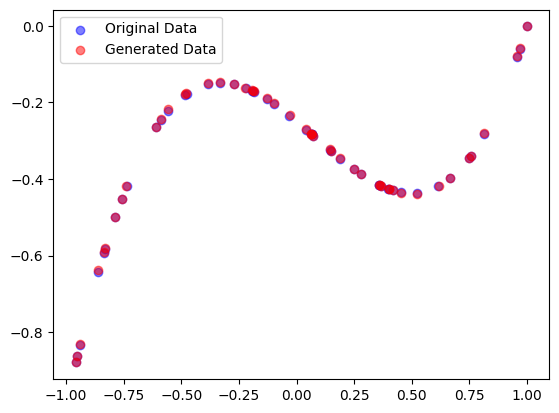

In [9]:
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

data_path = './HW4_prob2.csv'
data = pd.read_csv(data_path)

# data
X = torch.tensor(data.values, dtype=torch.float32)

# use data as inputs and outputs
dataset = TensorDataset(X, X)
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)

# define model
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
        
    def forward(self, x):
        return self.network(x)


input_size = X.size(1)
hidden_size = 50  
output_size = input_size  
model = Generator(input_size, hidden_size, output_size)

# loss function and optimizer
criterion = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 1000  
losses = []  
for epoch in range(num_epochs):
    for batch_features, _ in data_loader:
        
        batch_features = batch_features.to(torch.float32)
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        losses.append(loss.item())
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

with torch.no_grad():
    new_data = model(X).numpy()

plt.scatter(data['U1'], data['U2'], color='blue', alpha=0.5, label='Original Data')
plt.scatter(new_data[:, 0], new_data[:, 1], color='red', alpha=0.5, label='Generated Data')
plt.legend()
plt.show()


Epoch [100/1000], Loss: 0.0005
Epoch [200/1000], Loss: 0.0001
Epoch [300/1000], Loss: 0.0000
Epoch [400/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000


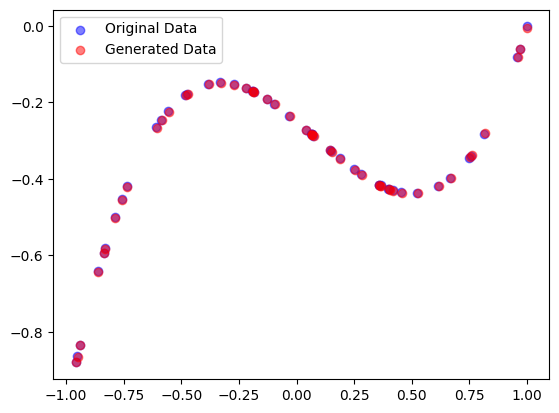

In [10]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.gru(x, hidden)
        out = self.fc(out[:, -1, :])  
        return out, hidden

input_size = 2  
hidden_size = 50  
num_layers = 1  
output_size = input_size  
gru_model = GRUModel(input_size, hidden_size, num_layers, output_size).to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(gru_model.parameters(), lr=0.001)


X_gru = X.unsqueeze(1)  

num_epochs = 1000
for epoch in range(num_epochs):
    hidden = None  
    for batch_features, _ in data_loader:
        
        optimizer.zero_grad()
        
        
        batch_features = batch_features.unsqueeze(1).to(device)
        
        
        outputs, hidden = gru_model(batch_features, hidden)
        # 我们不希望隐藏状态被梯度下降步骤影响
        # 因此我们将其从历史中分离出来
        hidden = hidden.detach()
        
        loss = criterion(outputs, batch_features[:, -1, :])
        
        loss.backward()
        optimizer.step()
        
    # output every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


with torch.no_grad():
    # 由于我们的数据不是真正的时序数据，我们将整个数据作为一个批次进行处理
    # 这样我们就可以生成与原数据相同数量的新数据点
    X_gru = X_gru.to(device)
    generated_data, _ = gru_model(X_gru, None)
    generated_data = generated_data.cpu().numpy()

# 绘制原始数据点和生成的数据点
plt.scatter(data['U1'], data['U2'], color='blue', alpha=0.5, label='Original Data')
plt.scatter(generated_data[:, 0], generated_data[:, 1], color='red', alpha=0.5, label='Generated Data')
plt.legend()
plt.show()

